In [2]:
import sys
import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output

from time import time,sleep
import math
import sklearn

In [3]:
### Averaging vectors
class run_aver:
    ## Initialize the object
    def __init__(self,alpha=0.0):
        self.t = 0.0
        self.s = None
        self.alpha = alpha

    def send(self,x):
        if self.t==0:
            self.s=x
        elif self.alpha==0:
            self.s=(x + self.t*self.s)/(self.t+1.0)
        else:
            self.s=self.alpha*x + (1-self.alpha)*self.s                           
        self.t+=1.0
        residual=x-self.s
        return residual
    
    def get_state(self):
        return self.s

    def get_sqrt(self):
        return math.sqrt(self.s)  # only for the case that the dimension is 1


In [19]:
d=1000
n=10000

results={}
a=np.zeros(3)
with open('Data.bin','rb') as f:
    a=np.fromfile(f,count=n*d)

X=a.reshape([n,d])

vals=range(20)

for e in vals:
    alpha=10**(-e/5.0)
    Av=run_aver(alpha=alpha)   # calculating the local average of the vectors
    err=[run_aver(alpha=0) for i in range(2)] # calculating the average of the errors
    L=[[],[]]
    for i in range(n-1):
        x=X[i,:]    # the i'th vector
        Nx=X[i+1,:] # the i+1'th vector
        err[0].send(np.dot(x,x)) # update the average error with a zero model
                                 # equivalently: the average square length of the vector x
        Av.send(x)          # Update the mean vector (uses alpha)     
        Px=Av.get_state()   # get the current mean vector
        r=Nx-Px             # compute the error wrt the mean vector
        err[1].send(np.dot(r,r)) # update the average error with the mean model

        L[0].append(err[0].get_state())
        L[1].append(err[1].get_state())
    results[e]=L

In [20]:
results.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

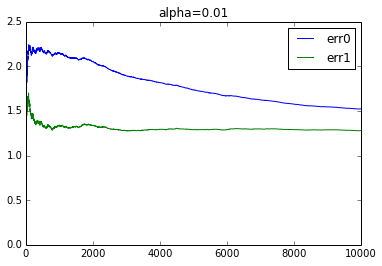

In [36]:
i=10
L=results[i]

plt.plot(range(len(L[0])),L[0],label='err0')
plt.plot(range(len(L[1])),L[1],label='err1')
plt.title('alpha='+str(10**(-i/5.0)))
plt.legend()

In [28]:
results_vec=[]
for e in vals:
    L=results[e]
    results_vec.append(L[1][-1])

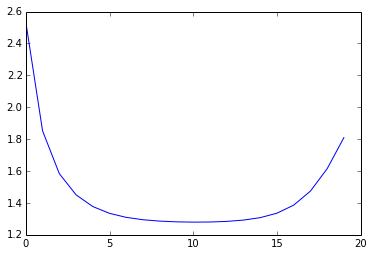

In [29]:
plt.plot(results_vec)

[oja's rule](http://en.wikipedia.org/wiki/Oja%27s_rule)

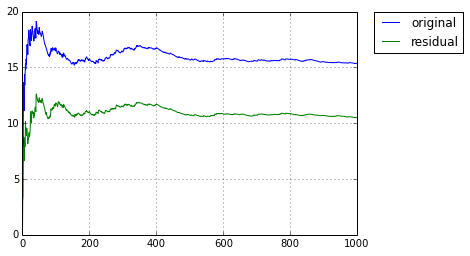

In [74]:
plt.plot(L[0],label='original')
plt.plot(L[1],label='residual')
#plt.ylim([0,200])
#plt.xlim([0,200])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

In [75]:
### Finding Eigen-Vectors
class run_Eigen:
    ## Initialize the object
    def __init__(self,alpha=0.0,beta=0.01):
        self.t = 0.0
        self.var = run_aver(alpha=0.01) # for estimating the 
        self.alpha=alpha
        self.beta=beta
        
    def send(self,x):
        if self.t==0:
            self.s=np.random.normal(x)
        else:
            s=self.s
            if self.alpha==0:
                s=s+(np.dot(s,x)*self.beta/math.sqrt(self.t))*x
            else:
                s=s+(np.dot(s,x)*self.alpha)*x
            Norm=LA.norm(s)
            if Norm>0: 
                s=s/Norm
            else:
                s=np.random.normal(x) 
            self.s=s
        self.t+=1.0
        
        dot=np.dot(self.s,x)
        self.var.send(dot*dot)
        residual=x-dot*self.s
        return residual
    
    def get_state(self):
        return self.s
    
    def get_var(self):
        return self.var.get_state()
    

In [81]:
kk=2 # number of eigen-vectors to search for.

# The modeling pipeline
Av=run_aver(alpha=0)  # find the mean
Eig=[run_Eigen(alpha=0.01,beta=0.1) for i in range(kk)] # find the first kk eigen-vectors

# Compute the errors 
err=[run_aver(alpha=0) for i in range(kk+2)] # compute the average length of the residual.
sz=np.shape(X)[0]
L=[np.zeros(sz) for i in range(kk+2)]

### A convinience function to perform a single update single update
def one_step():
    x=X[i,:]
    err[0].send(np.dot(x,x))
    L[0][i]=err[0].get_sqrt()
    r1=Av.send(x)
    err[1].send(np.dot(r1,r1))
    L[1][i]=err[1].get_sqrt()/L[0][i]
    r2=r1
    for j in range(kk):
        r2=Eig[j].send(r2)
        err[j+2].send(np.dot(r2,r2))
        L[j+2][i]=err[j+2].get_sqrt()/L[0][i]


In [82]:
np.shape(X)

(1000, 2)

In [83]:
History=[]
V=[0]*2

for i in range(n):
    one_step()
    Mean=Av.get_state()
    #print i,Mean
    for j in range(2):
        V[j]=2*(Eig[j].get_state())

    History.append({'index':i,
                    'Mean':Mean,
                    'X':X[i,:],
                    'V':V})
    
#    data_point=ax.scatter(X[i,0],X[i,1],c='r')
#    mean_point=ax.scatter(Mean[0], Mean[1],c='g',s=100)

#    ax.set_title(label='iteration '+str(i))
#    plt.xlim([-10,10])
#    plt.ylim([-10,10])
    #sleep(0.1)
#    clear_output(wait=True)
#    display(f)
    
# plt.close()

In [84]:
len(History)

1000

In [88]:
from JSAnimation import IPython_display
import matplotlib as mpl
from matplotlib import animation
from matplotlib import collections  as mc
    
fig=plt.figure(num=None, figsize=(10.0, 10.0), dpi=80, facecolor='w', edgecolor='k')
ax=plt.axes()
plt.xlim([-10,10])
plt.ylim([-10,10])

ax.scatter(X[:,0],X[:,1])
ax.grid()

# overlay the animation

lines=[[[0,0],[0,0]],[[0,0],[0,0]]] #,[[0,0],[0,0]]]
c = np.array([(1, 0, 0, 1), (0, 1, 0, 1)]) #,(0, 0, 1, 1)])
lc = mc.LineCollection(lines, colors=c, linewidths=2)

ax.add_collection(lc)

marks = ax.plot([],[],'k+')+ ax.plot([],[],'r*')

angles=np.linspace(0,2*np.pi,20)
def init():
    #lc.set_segments(pointer(0))
    return lc,

def animate(i):
    if i%100 == 1:
        print i,
    H=History[i]
    Mean=H['Mean']
    lines=[[Mean,H['X']]]+[[Mean,Mean+3*H['V'][i]] for i in [0]]
    #print i,lines
    lc.set_segments(lines)
    marks[0].set_data(lines[0][1])
    marks[1].set_data(lines[1][1])
    return lc,marks

animation.FuncAnimation(fig, animate,range(n), init_func=init,blit=True)


1 101 201 301 401 501 601 701 801 901

AssertionError: 

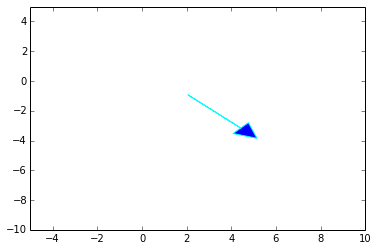

In [17]:
fig = plt.figure()
ax = plt.axes(xlim=(-5, 10), ylim=(-10, 5))

arrow=ax.arrow(Mean[0],Mean[1], V[0], V[1], head_width=1, head_length=1,ec=plt.cm.cool(color_idx[i % n_color]))
sleep(1)
arrow.set_xy([0,0])


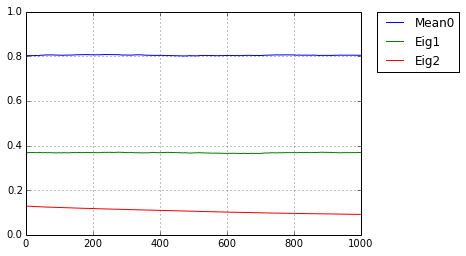

In [77]:

for i in range(sz):
    one_step()
    
#plt.plot(L[0],label='original')
plt.plot(L[1],label='Mean0')
for j in range(kk):
    plt.plot(L[j+2],label='Eig%d'%(j+1))
plt.ylim([0,1])
#plt.xlim([0,200])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

**Home Work** You will be given a 1GB file with d=100 vectors. Your task is to perform PCA online efficiently on this data and report how the vectors change as a function of time.